In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
import hdbscan

import time

In [2]:
#!source /Users/lui/Documents/3_semestr/Project/env_project/env_project_dap/bin/activate

## Identifying clusters in the 100 pc sphere

<span style="font-size:18px;">

* Clustering in the 100 pc sphere is a challenging task.
* The data is un-evenly dense in two respective subspaces. Especially the velocity space is subject to strong non-linear projection effects.
* An originally compact Gaussian point cloud can result in a highly non-convex shape in the velocity space.

Let's see what this might look like in practice.

</span>

In [3]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [4]:
# Create 6D Gaussian data
n = 500 #1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_bg = np.where(labels==0)[0]

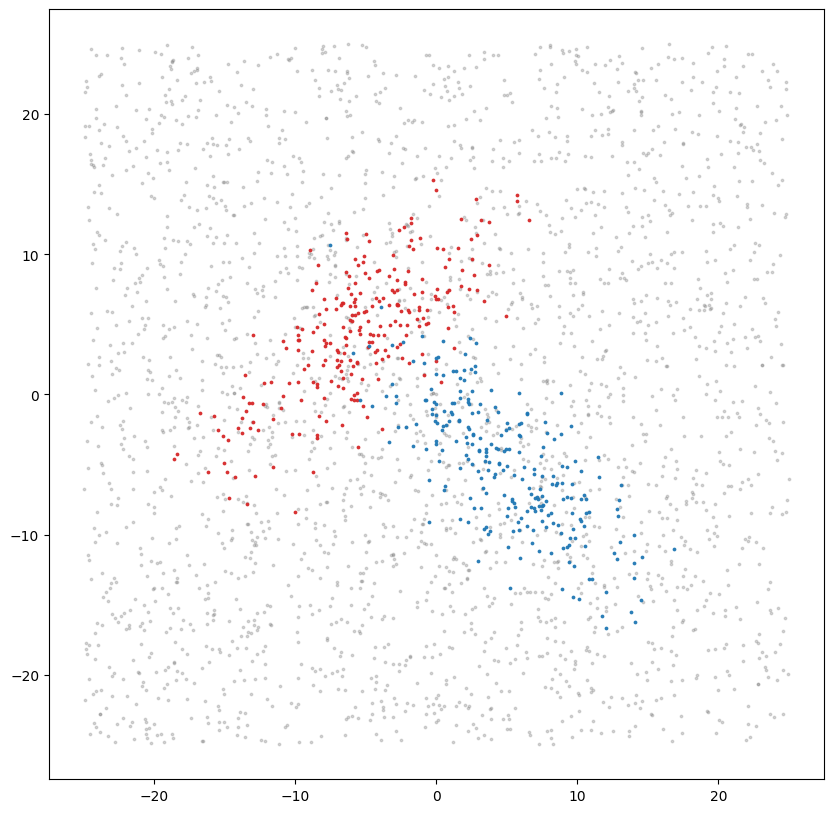

In [5]:
x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'

fig = plt.figure(figsize=(10, 10))
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders):
    # if c == 'tab:blue':
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
# plt.xlim(-1000, 1000)
# plt.ylim(-1000, 1000)

# Optimal radial velocity class
VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

In [6]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

# Now built the distance matrix for clustering ourselves

In [7]:
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

## Compute the semi-cohesion metric

<span style="font-size:18px;">

Given a semi-metric d(·,·) for $\Omega$, we define the induced semi-cohesion measure as follows:

$$ g(x, y) = \frac{1}{n} \sum_{z_2 \in \Omega} d(z_2, y) + \frac{1}{n} \sum_{z_1 \in \Omega} d(x, z_1) - \frac{1}{n^2}  \sum_{z_2 \in \Omega} \sum_{z_1 \in \Omega} d(z_2, z_1) - d(x, y) $$ 

</span>


In [8]:
# Compute semi-cohesion metric G
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

In [9]:
G

array([[ 17.54054169,  13.34594888, -20.66035798, ...,   9.05461444,
         10.11149663,  -7.16140118],
       [ 13.34594888,  24.57948025,  -7.43838024, ...,   3.15837205,
         11.44566226, -13.01776754],
       [-20.66035798,  -7.43838024,  18.74420726, ...,  -7.88168903,
         -2.60361202,   7.77321504],
       ...,
       [  9.05461444,   3.15837205,  -7.88168903, ...,   9.19384384,
          7.60317538,   6.07747157],
       [ 10.11149663,  11.44566226,  -2.60361202, ...,   7.60317538,
          8.69359673,   5.95352996],
       [ -7.16140118, -13.01776754,   7.77321504, ...,   6.07747157,
          5.95352996,   4.8387189 ]])

## Compute the semi-cohesion metric - direct way (just to see if I get the same results)

In [10]:
n = dist_v_opt.shape[0]

row_sum = np.sum(dist_v_opt, axis=1)  #Sum of distances for each row
col_sum = np.sum(dist_v_opt, axis=0)  #Sum of distances for each column

#Sum of all pairwise distances
total_sum = np.sum(dist_v_opt)  

#Semi-cohesion matrix G
G_direct = np.zeros_like(dist_v_opt)  

for i in range(n):
    for j in range(n):
        G_direct[i, j] = (row_sum[j] / n) + (col_sum[i] / n) - (total_sum / n**2) - dist_v_opt[i, j]


In [11]:
G_direct

array([[ 17.54054169,  13.34594888, -20.66035798, ...,   9.05461444,
         10.11149663,  -7.16140118],
       [ 13.34594888,  24.57948025,  -7.43838024, ...,   3.15837205,
         11.44566226, -13.01776754],
       [-20.66035798,  -7.43838024,  18.74420726, ...,  -7.88168903,
         -2.60361202,   7.77321504],
       ...,
       [  9.05461444,   3.15837205,  -7.88168903, ...,   9.19384384,
          7.60317538,   6.07747157],
       [ 10.11149663,  11.44566226,  -2.60361202, ...,   7.60317538,
          8.69359673,   5.95352996],
       [ -7.16140118, -13.01776754,   7.77321504, ...,   6.07747157,
          5.95352996,   4.8387189 ]])

In [12]:
np.allclose(G, G_direct) 

True

## Implement the K-sets+ algorithm

<span style="font-size:18px;">
Implement the K-sets+ algorithm from this paper that uses the above computed semi-cohesion metric, see [here](https://arxiv.org/pdf/1705.04249).

</span>

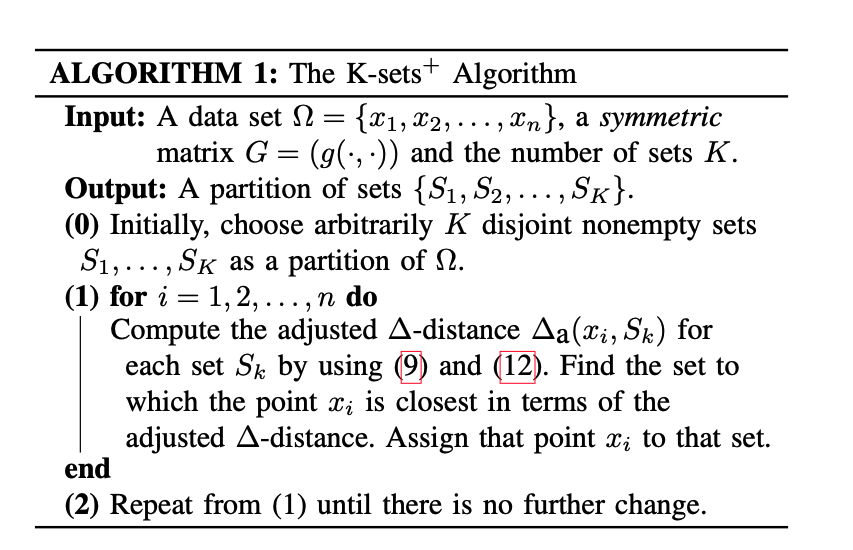

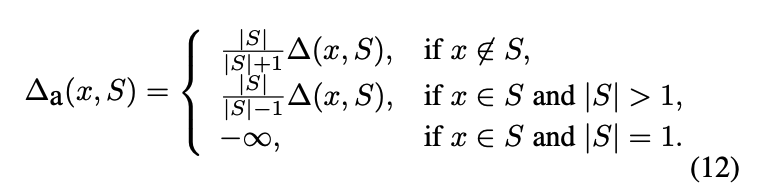

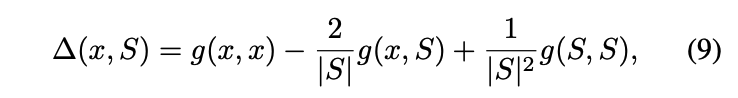

In [13]:
from IPython.display import display, Image
display(Image(filename='img/kset_alg.png'))
display(Image(filename='img/kset_alg2.png'))
display(Image(filename='img/kset_alg3.png'))

In [14]:
import time
from sklearn.cluster import KMeans

def ksets_plus(G, K, max_iter = 20, method = "random"):

    start_time = time.time()
    np.random.seed(42)
    n = G.shape[0]

    # Initial K disjoint sets
    if method == "random":
        sets = np.random.randint(0, K, size=n) 
    elif method == "kmeans":
        kmeans = KMeans(n_clusters=K, random_state=42)
        sets = kmeans.fit_predict(df[['x', 'y', 'z']].values)
    else:
        ValueError("Invalid method")
        
        
    for iteration in range(max_iter):
        changes = 0  # Track changes

        for i in range(n):
            best_cluster = sets[i]
            min_distance = np.inf

            for k in range(K):
                S_k = np.where(sets == k)[0]  # Get indices of all points in set
                
                if len(S_k) == 0:
                    continue  
                
                # Compute adjusted distance
                if i not in S_k:
                    # Point is outside set
                    distance = (len(S_k) / (len(S_k) + 1)) * (G[i, i] - 2 * G[i, S_k].sum() / len(S_k) + G[S_k][:, S_k].sum() / (len(S_k) ** 2))

                    # Point is inside set
                else:
                    if len(S_k) > 1:
                        distance = (len(S_k) / (len(S_k) - 1)) * (G[i, i] - 2 * G[i, S_k].sum() / len(S_k) + G[S_k][:, S_k].sum() / (len(S_k) ** 2))
                    else:
                        distance = -np.inf

                # Find the closest set
                if distance < min_distance:
                    min_distance = distance
                    best_cluster = k
            
            if sets[i] != best_cluster:
                sets[i] = best_cluster
                changes += 1

        # If no further changes => stop
        if changes == 0:
            break

    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f'Execution time: {minutes} minutes and {seconds} seconds')
    print(f'Number of iterations {iteration + 1}')

    return sets

In [15]:
# Plotting clusters depending on x_col and y_col
def plot_clusters(df, cluster_labels, true_labels, K, x_col, y_col):
    fig, ax = plt.subplots(1, K, figsize=(5*K, 5))
    for l_i in np.unique(cluster_labels):
        if l_i != -1:
            idx_sel = cluster_labels == l_i
            ax[l_i].scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s = 3, alpha = 0.8, zorder = 1, c = true_labels[idx_sel])
            ax[l_i].set_xlabel(x_col)
            ax[l_i].set_ylabel(y_col)
    plt.tight_layout()
    plt.show()


In [16]:
K = 3  
labels_ksets_random = ksets_plus(G, K, method = "random")

Execution time: 4 minutes and 34 seconds
Number of iterations 9


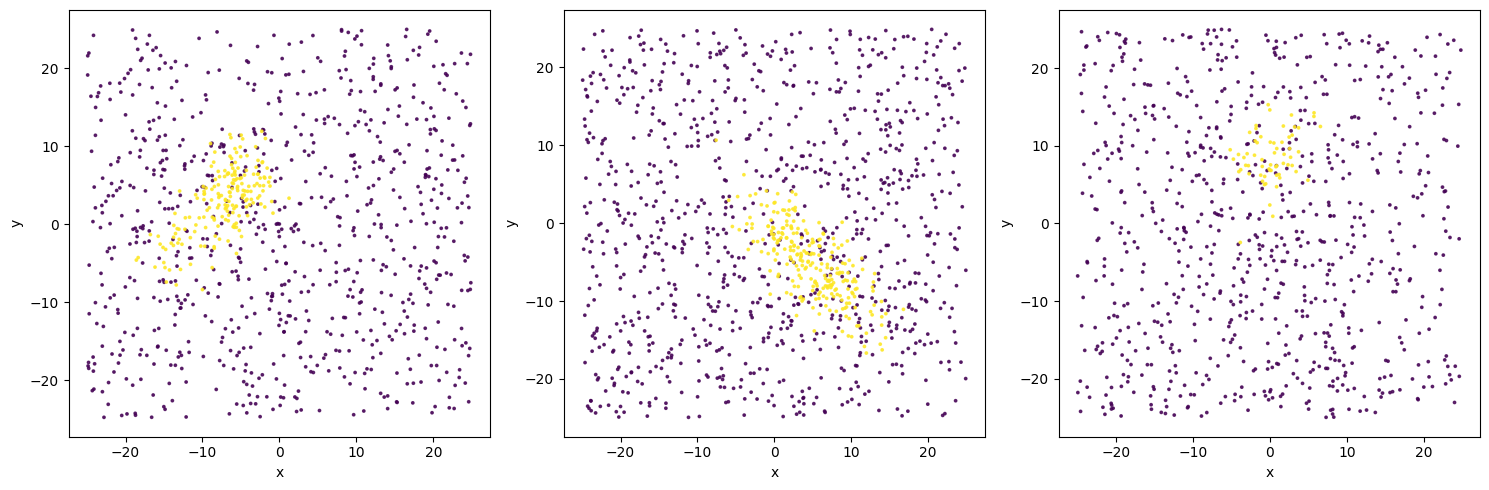

In [17]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_ksets_random, labels, K, x_col, y_col)

In [18]:
def ksets_plus_optimized(G, K, max_iter=100, method="random"):

    start_time = time.time()
    n = G.shape[0]
    np.random.seed(42)

    # Initialize K disjoint sets
    if method == "random":
        sets = np.random.randint(0, K, size=n)
    elif method == "kmeans":
        kmeans = KMeans(n_clusters=K, random_state=42)
        sets = kmeans.fit_predict(df[['x', 'y', 'z']].values)
    else:
        raise ValueError("Invalid method")
        

    for iteration in range(max_iter):
        
        changes = 0 # Track changes

        
        G_diag = np.diag(G) # Precompute diagonal of G, G[x,x]

        # Compute current cluster sizes |S| - necessary for computing adjusted distances
        cluster_sizes = np.array([np.sum(sets == k) for k in range(K)])

        # Binary matrix to track whether point belongs to specific set
        membership_matrix = np.zeros((n, K))
        for k in range(K):
            membership_matrix[:, k] = (sets == k).astype(int)

        # Compute G[S, S] 
        set_sums = membership_matrix.T @ G @ membership_matrix

        # Compute G[x, S] 
        point_set_sums = G @ membership_matrix

   
        distances = np.zeros((n, K))
        for k in range(K):

            s_size = cluster_sizes[k]

            if s_size == 0:
                continue

            outside_sets = (sets != k)
            inside_sets = (sets == k)

            # For points outside set
            distances[outside_sets, k] = ((s_size / (s_size + 1)) * (G_diag[outside_sets] - 2 * point_set_sums[outside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))

            # For points inside set
            if s_size > 1:
                distances[inside_sets, k] = ((s_size / (s_size - 1)) * (G_diag[inside_sets] - 2 * point_set_sums[inside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))
            else:
                distances[inside_sets, k] = -np.inf  

        # Assign points to set with minimum distance
        best_clusters = np.argmin(distances, axis=1)

        # Number of changes
        changes = np.sum(sets != best_clusters)

        sets = best_clusters

        # If no further changes => stop
        if changes == 0:
            break

    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations: {iteration + 1}')

    return sets


In [19]:
K = 3  
labels_ksets_opt = ksets_plus_optimized(G, K, method = "random")

Execution time: 0 minutes, 0 seconds and 383 ms
Number of iterations: 47


In [20]:
# get number of clusters
unique_clusters = np.unique(labels_ksets_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

3


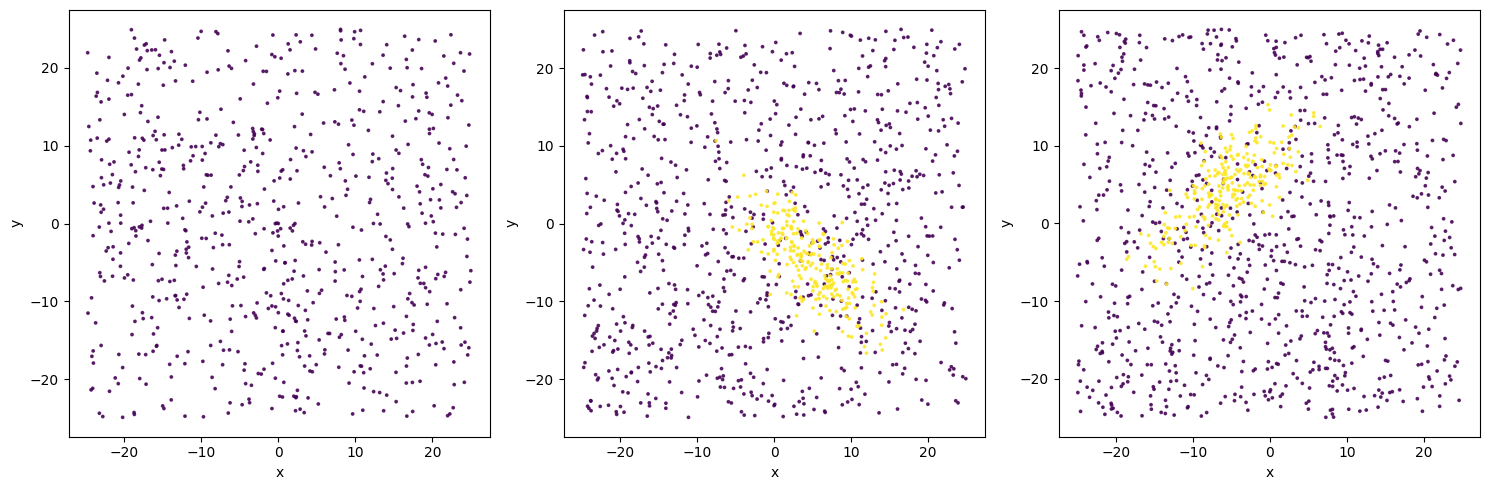

In [21]:
x_col, y_col = 'x', 'y'
plot_clusters(df, labels_ksets_opt, labels, K, x_col, y_col)

## Implement the Softmax Clustering Algorithm

from this paper https://arxiv.org/abs/1708.00316

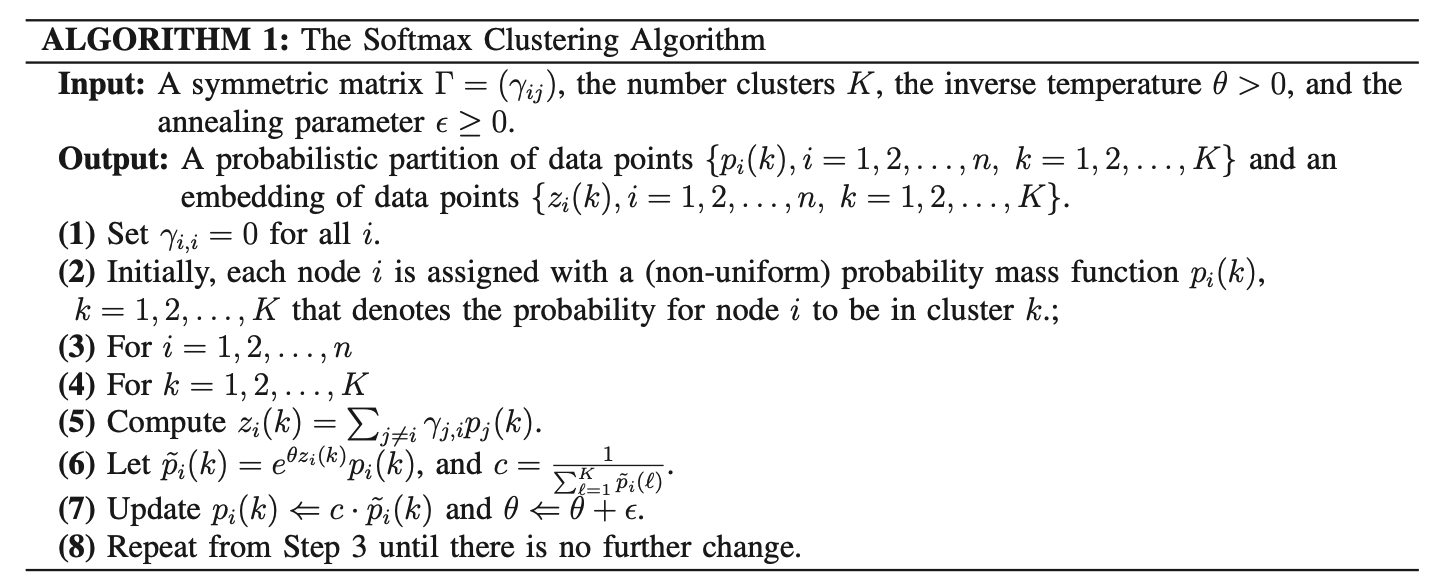

In [22]:
display(Image(filename='img/softmax_alg.png'))

In [23]:
def softmax_clustering(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250):
  
    start_time = time.time()
    
    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0] #size

    np.random.seed(42)

    # Initialize each node i with (non-uniform) probability mass function pi(k)
    p_i = np.random.dirichlet(np.ones(K), size=n) 
    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        for i in range(n):
            for k in range(K):
                z[i, k] = np.sum(Gamma[i, :] * p_i[:, k])  # Compute covariance
        
  
        for i in range(n):
            p_t = np.exp(theta * z[i, :]) * p_i[i, :]  # Softmax function
            c = 1 / np.sum(p_t)  
            p_i[i, :] = c * p_t  # Update probability uisng softmax function

     
        theta += epsilon

        # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()

    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations: {iteration + 1}')

    return p_i, z

In [24]:
K = 6
p_i, z = softmax_clustering(G, K)

#print("Probability partition of data points (pi):")
#print(p_i)
#print("Embedding of data points(z):")
#print(z)

Execution time: 0 minutes, 21 seconds and 993 ms
Number of iterations: 247


In [25]:
# get clusters from probability
def get_clusters(p_i):

    cluster_labels = np.argmax(p_i, axis=1)
    _, relabeled_clusters = np.unique(cluster_labels, return_inverse=True)
    
    return relabeled_clusters


In [26]:
# get cluster labels and number of clusters
labels_softmax= get_clusters(p_i) 
unique_clusters = np.unique(labels_softmax)
num_clusters = len(unique_clusters)
print(num_clusters)

4


In [27]:
unique_clusters

array([0, 1, 2, 3])

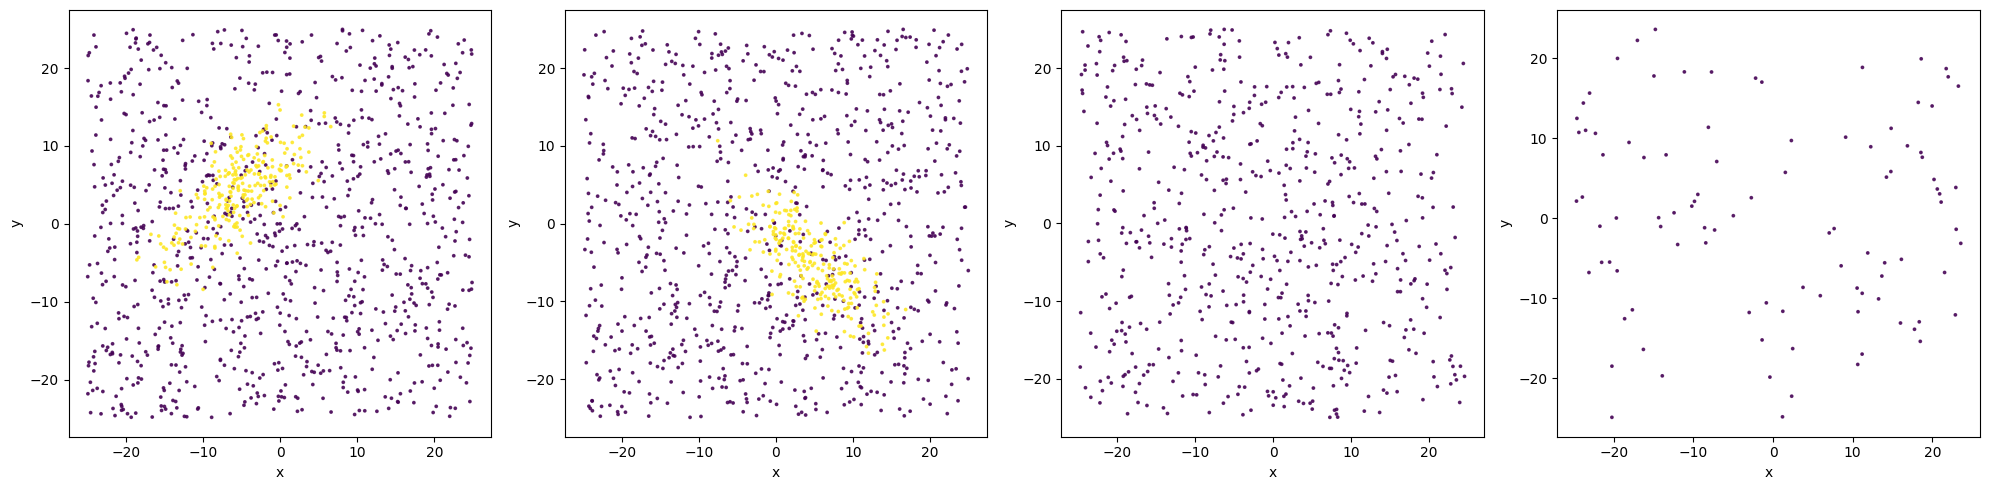

In [28]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax, labels, num_clusters, x_col, y_col)

In [29]:
def softmax_clustering_optimized(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250):

    start_time = time.time()

    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0]

    np.random.seed(42)

    # Initialize each node i with (non-uniform) probability mass function pi(k)
    p_i = np.random.dirichlet(np.ones(K), size=n) 
    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        # Compute covaraince (z)for all points and clusters
        z = Gamma @ p_i 

        p_t = np.exp(theta * z) * p_i  # Softmax function
        p_i = p_t / np.sum(p_t, axis=1, keepdims=True)  # Update probability uisng softmax function and normalize it (it must sum to 1)

        theta += epsilon

         # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()
        
    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations (softmax): {iteration + 1}')

    return p_i, z


In [30]:
def softmax_clustering_optimized_iphd(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250, initial_partition=None):

    start_time = time.time()

    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0]

    np.random.seed(42)

    # Use the initial partition if provided, otherwise initialize randomly
    if initial_partition is not None:
        p_i = initial_partition
    else:
        p_i = np.random.dirichlet(np.ones(K), size=n)

    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        # Compute covaraince (z)for all points and clusters
        z = Gamma @ p_i 

        p_t = np.exp(theta * z) * p_i  # Softmax function
        p_i = p_t / np.sum(p_t, axis=1, keepdims=True)  # Update probability uisng softmax function and normalize it (it must sum to 1)

        theta += epsilon

         # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()
        
    execution_time = time.time() - start_time
    print(f'Execution time (softmax): {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations (softmax): {iteration + 1}')

    return p_i, z

In [31]:
K = 6
p_i_opt, z_opt = softmax_clustering_optimized_iphd(G, K)

#print("Probability partition of data points (pi):")
#print(p_i_opt)
#print("Embedding of data points(z):")
#print(z_opt)


Execution time (softmax): 0 minutes, 1 seconds and 416 ms
Number of iterations (softmax): 247


In [32]:
# get cluster labels and number of clusters
labels_softmax_opt= get_clusters(p_i_opt) 
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

4


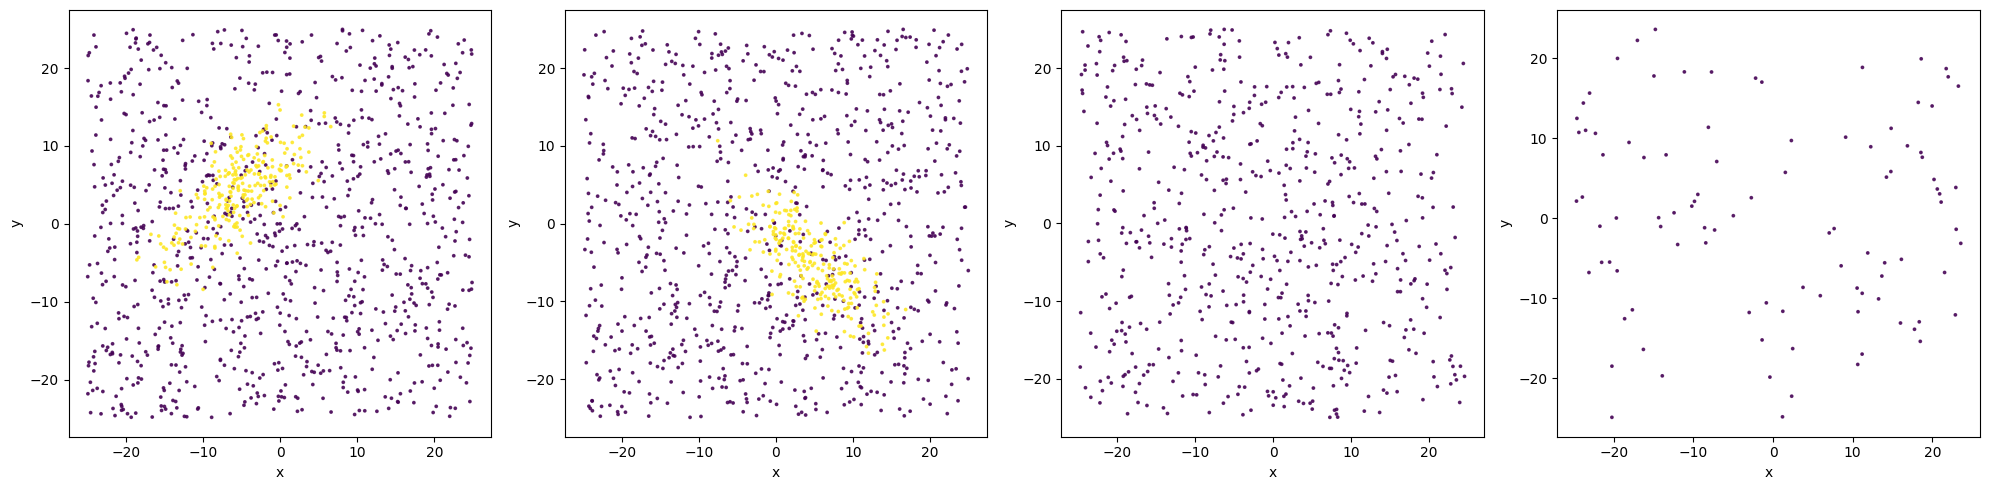

In [33]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax_opt, labels, num_clusters, x_col, y_col)

## The Hierarchical Agglomerative Algorithm
https://dl.acm.org/doi/10.1109/TNET.2017.2762403

In [34]:
# equation (9) 
def compute_transition_probability(G, p_lambda = 1):

    n = G.shape[0]
    # Row sum for each node i 
    degrees = G.sum(axis=1) + 1e-10  # to avoid division by zero
    transition_prob = (1 - p_lambda) / n + p_lambda * (G / degrees[:, None])

    # Needed to avoid overflow and underflow
    transition_prob = np.maximum(np.minimum(transition_prob, 1 - 1e-10), 1e-10)
    return transition_prob

# equation (10)
def compute_steady_probability(G, p_lambda= 1, tol=1e-6, max_iter=100):
    
    n = G.shape[0]
    pi = np.ones(n) / n  
    transition_prob= compute_transition_probability(G, p_lambda)

    for _ in range(max_iter):
        pi_new = (1 - p_lambda) / n + p_lambda * transition_prob.T @ pi

        # Normalize to avoid large values in pi_new
        pi_new /= np.sum(pi_new)
        if np.linalg.norm(pi_new - pi, 1) < tol:
            break
        pi = pi_new

    return pi

def compute_correlation_matrix(G, p_lambda=1):

    # equations (11), (27)
    pi_v = compute_steady_probability(G, p_lambda)
    
    transition_prob = compute_transition_probability(G, p_lambda)
    
    # equation (11)
    p_vw = (pi_v.reshape(-1, 1) * np.ones(G.shape[0])) * transition_prob

    p_V = p_vw.sum(axis=1)
    p_W = p_vw.sum(axis=0)

    # Set threshold to avoid overflow and nans
    p_vw = np.maximum(np.minimum(p_vw, 1e10), 1e-10)
    p_V = np.maximum(np.minimum(p_V, 1e10), 1e-10)
    p_W = np.maximum(np.minimum(p_W, 1e10), 1e-10)
    
    # equation (27)
    q = 0.5 * (p_vw - (p_V.reshape(-1, 1) * p_W) + p_vw.T - (p_W.reshape(-1, 1) * p_V))
    return q


In [35]:
# different sampling method
'''
# equation (4) - uniform edge sampling
def compute_uniform_edge_probability(G):
    m = np.sum(G)  
    p_vw = G / m   # p(v, w) = a_vw / m
    return p_vw

def compute_correlation_matrix(G):

    p_vw = compute_uniform_edge_probability(G)

    p_V = p_vw.sum(axis=1)  
    p_W = p_vw.sum(axis=0)  

    # Set threshold to avoid overflow and nans
    p_vw = np.maximum(np.minimum(p_vw, 1e10), 1e-10)
    p_V = np.maximum(np.minimum(p_V, 1e10), 1e-10)
    p_W = np.maximum(np.minimum(p_W, 1e10), 1e-10)
    

    # equation (27)
    q = 0.5 * (p_vw - (p_V.reshape(-1, 1) * p_W) + p_vw.T - (p_W.reshape(-1, 1) * p_V))

    
    return q  

'''


'\n# equation (4) - uniform edge sampling\ndef compute_uniform_edge_probability(G):\n    m = np.sum(G)  \n    p_vw = G / m   # p(v, w) = a_vw / m\n    return p_vw\n\ndef compute_correlation_matrix(G):\n\n    p_vw = compute_uniform_edge_probability(G)\n\n    p_V = p_vw.sum(axis=1)  \n    p_W = p_vw.sum(axis=0)  \n\n    # Set threshold to avoid overflow and nans\n    p_vw = np.maximum(np.minimum(p_vw, 1e10), 1e-10)\n    p_V = np.maximum(np.minimum(p_V, 1e10), 1e-10)\n    p_W = np.maximum(np.minimum(p_W, 1e10), 1e-10)\n    \n\n    # equation (27)\n    q = 0.5 * (p_vw - (p_V.reshape(-1, 1) * p_W) + p_vw.T - (p_W.reshape(-1, 1) * p_V))\n\n    \n    return q  \n\n'

In [36]:

def hierarchical_agglomerative_clustering(G, initial_partition, min_correlation_threshold=0):
   
    # equation (27)
    q = compute_correlation_matrix(G)
    clusters = [set(cluster) for cluster in initial_partition]
    
    while True:
        n = len(clusters)
        cluster_corr = np.zeros((n, n))

        # Calculate q(Si, Sj, equation (28)
        for i in range(n):
            for j in range(i + 1, n):
                cluster_corr[i, j] = np.sum(q[np.ix_(list(clusters[i]), list(clusters[j]))])
                #because q(Si, Sj) = q(Sj, Si)
                cluster_corr[j, i] = cluster_corr[i, j]

        # Look for pair with maximum positive correlation
        max_value = -np.inf  
        i, j = -1, -1        
        for row in range(cluster_corr.shape[0]):
            for col in range(row + 1, cluster_corr.shape[1]):  
                if not np.isnan(cluster_corr[row, col]) and cluster_corr[row, col] > max_value:
                    max_value = cluster_corr[row, col]
                    i, j = row, col
        
        # Use some min_correlation_threshold instead of 0, attempt to stop merging into one cluster
        if cluster_corr[i, j] <= min_correlation_threshold:
            break

        # Merge Si and Sj
        new_cluster = clusters[i].union(clusters[j])
        clusters = [clusters[k] for k in range(n) if k != i and k != j]
        clusters.append(new_cluster)

        # Update correlations for new merged cluster
        new_n = len(clusters)
        new_cluster_corr = np.zeros((new_n, new_n))
        
        # Copy over existing correlations
        for k in range(new_n - 1):
            for l in range(new_n - 1):
                new_cluster_corr[k, l] = cluster_corr[k, l]
        
        # equation (30)
        new_idx = new_n - 1
        new_cluster_corr[new_idx, new_idx] = (
            cluster_corr[i, i] + 2 * cluster_corr[i, j] + cluster_corr[j, j]
        )

        # equation (31)
        for l in range(new_n - 1):
            new_cluster_corr[new_idx, l] = cluster_corr[i, l] + cluster_corr[j, l]
            new_cluster_corr[l, new_idx] = new_cluster_corr[new_idx, l]
        
        cluster_corr = new_cluster_corr
    
    return clusters


## The Iterative Partitional-Hierarchical (iPHD) Algorithm

In [37]:
# To be able to compare labels for softmax_clustering and hierarchical_agglomerative_clustering
def normalize_labels(labels):
    _, normalized_labels = np.unique(labels, return_inverse=True)
    return normalized_labels

def iphd_algorithm(Gamma, initial_K, theta=0.001, epsilon=0.0001, max_iter=500, nmi_threshold=0.99):
    
    start_time = time.time()
    n = Gamma.shape[0]
    K = initial_K  
    iteration = 0

    p_i, z = softmax_clustering_optimized_iphd(Gamma, K, theta, epsilon, max_iter)
    
    while True:
        iteration += 1

        prev_labels = normalize_labels(np.argmax(p_i, axis=1))

        softmax_partition = [np.where(prev_labels == k)[0] for k in np.unique(prev_labels)]

        print("Number of clusters after using softmax:", np.unique(prev_labels))

        new_partition = hierarchical_agglomerative_clustering(Gamma, softmax_partition)


        # Get labels from partition format
        new_labels = np.zeros(n, dtype=int)
        for idx, cluster in enumerate(new_partition):
            new_labels[list(cluster)] = idx
        new_labels = normalize_labels(new_labels)

        nmi_score = normalized_mutual_info_score(prev_labels, new_labels)
        print(f"NMI score between iterations: {nmi_score:.4f}")

        if nmi_score >= nmi_threshold:
            break

        prev_labels = new_labels

        # Get partition for input to  softmax using output partition form  hierarchical_agglomerative_clustering
        initial_p_i = np.zeros((n, K))
        for k, cluster in enumerate(new_partition):
            initial_p_i[list(cluster), k] = 1 
        
        p_i, z = softmax_clustering_optimized_iphd(Gamma, K, theta, epsilon, max_iter, initial_partition=initial_p_i)

    # Calculate corresponding embedding for final partition
    embeddings = np.zeros((n, len(new_partition)))
    for k, cluster in enumerate(new_partition):
        for i in cluster:
            embeddings[i, k] = np.sum([Gamma[i, j] for j in cluster])

    execution_time = time.time() - start_time
    print(f'Execution time (iphd): {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations (iphd): {iteration}')

    return new_partition, embeddings


In [47]:
initial_K = 9
final_partitions, embeddings = iphd_algorithm(G, initial_K)

#print("Final partitions:", final_partitions)
print("Embeddings shape:", embeddings.shape)

Execution time (softmax): 0 minutes, 1 seconds and 648 ms
Number of iterations (softmax): 248
Number of clusters after using softmax: [0 1 2]
NMI score between iterations: 1.0000
Execution time (iphd): 0 minutes, 2 seconds and 562 ms
Number of iterations (iphd): 1
Embeddings shape: (3000, 3)


In [48]:
# Convert into label array 
def get_iphd_labels(final_clusters, n_samples):
    labels = -np.ones(n_samples, dtype=int)  
    for cluster_id, cluster in enumerate(final_clusters):
        labels[list(cluster)] = cluster_id
    return labels

In [49]:
labels_iphd = get_iphd_labels(final_partitions, len(df))
num_clusters = len(final_partitions)
print(labels_iphd)
print(num_clusters)

[0 2 1 ... 0 0 0]
3


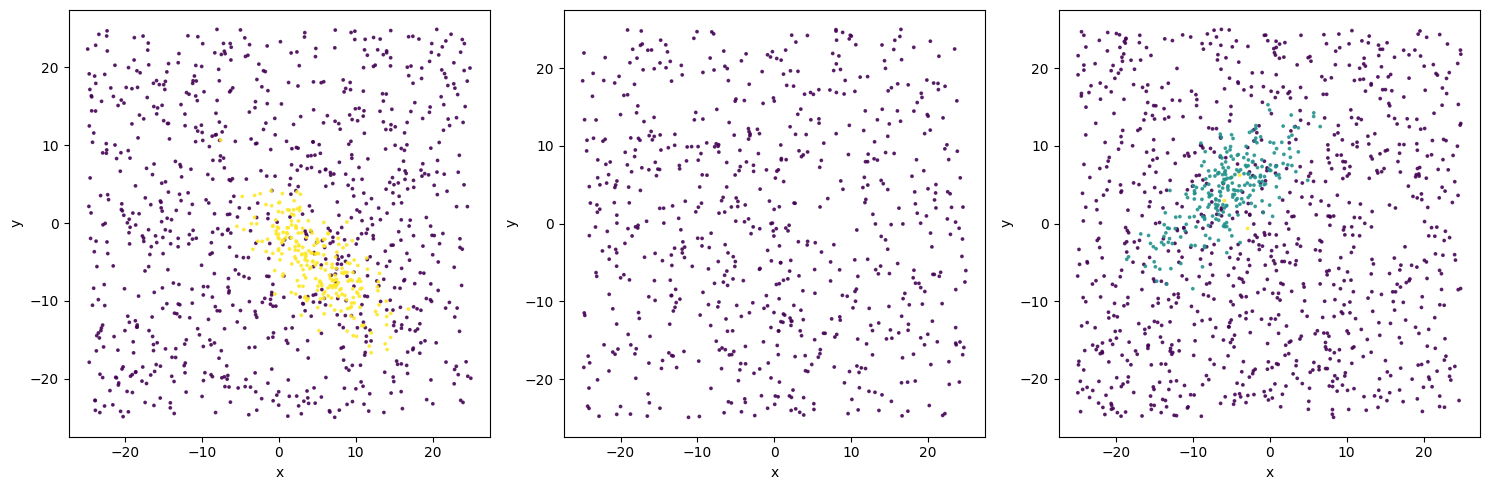

In [50]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_iphd, labels, num_clusters, x_col, y_col)